In [28]:
import logging
import pickle
import time
from statistics import mean, median

import en_core_web_sm
import gensim.utils
import gensim.models.keyedvectors
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import seaborn as sns
import spacy
import string

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from imblearn.under_sampling import RandomUnderSampler
from keras_preprocessing.sequence import pad_sequences

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.tokenize import word_tokenize, sent_tokenize

from sklearn import svm
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.preprocessing import MinMaxScaler # for multinomial
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
nltk.download('punkt')

logging.basicConfig(format="%(message)s")
logger = logging.getLogger()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Kika\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Funkcia na predspracovanie textu

In [3]:
def text_preprocessing(text):  
    try:
        # Prevediem písmená slova na malé písmená
        text = text.lower()
    
        # Odfiltrujem text
        text = re.sub(r"(@\[A-Za-zÀ-ž0-9]+)|([^0-9A-Za-zÀ-ž \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
        
        # Odstránim slová, ktoré obsahujú čísla
        text = re.sub(r'\w*\d\w*', '', text)

        # Odstránim čísla samotné
        text = re.sub(r'[0-9]+', '', text)

        # Odstránim všetky biele znaky
        text = re.sub(r'\s+', ' ', text).strip()
    
        # Prevediem text vety  
        text = word_tokenize(text)
        
        # Ak sú nejaké prázdne stringy, tak ich odstránim
        text = [x for x in text if x!='']

        # Odstránim slov slová.
        text = [x for x in text if x not in stop_words]
    
        # Zlemmatizujem.
        text = [lemmatizer.lemmatize(x) for x in text]
    except:
        return None
    
    return text

# 6 - Načítanie slovných vektorov (potrebné C) 5.3 krok - vektory)

### 6* Netreba zabudnúť, že pri úprave klasifikačného datasetu sa využívajú slovné vektory, preto všetky ďalšie kroky treba VŽDY spustiť, ak meníme model vektorov

In [65]:
#Tu treba zmeniť konkrétny model, kde sú uložené slovné vektory
#Vektory pre NEUPRAVENÉ VETY = 0
#Vektory pre UPRAVENÉ VETY (o synonymá) = 1

file = 1
if file == 0:
    file = "model_CBOW_dim_150_202303231257_sentences"
    sentence_type = "sentences"
else:
    file = "model_CBOW_dim_150_202303231259_sentences_new"
    sentence_type = "sentences_new"

In [66]:
model = KeyedVectors.load_word2vec_format("files/"+file+".bin", binary=True, unicode_errors='replace')

# načítanie slovných vektorov z modelu
embedding_matrix = model.vectors
embedding_size = embedding_matrix.shape[1]
word_index = model.key_to_index

# 7 - Načítanie datasetu FakeNews a jeho predspracovanie

### 7.1 Očistenie a spočítanie slov

In [8]:
# https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification
# Stačí raz zbehnúť
df = pd.read_csv("files/WELFake_Dataset.csv")

# odstránenie zbytočných štĺpcov a duplikátov
df.drop(labels = ["Unnamed: 0", "title"], axis = 1, inplace=True)
df.drop_duplicates(inplace = True)
df.reset_index(drop=True, inplace=True)

# očistenie textu a odstránenie NaN záznamov a spočítanie slov
df['text_clean'] = df['text'].apply(lambda x: text_preprocessing(x))
df.reset_index(drop=True, inplace=True)
df = df.dropna(subset=['text_clean'], how='any')
df['word_count'] = df['text_clean'].apply(len)

# odstránenie stlpcu text a záznamov, ktoré obsahujú 0 slov
df.drop(labels = ["text"], axis = 1, inplace=True)
df = df.loc[df['word_count'] != 0]
df.reset_index(drop=True, inplace=True)

df.to_csv('files/fake_news_clean.csv', index=False, header=True, encoding='utf-8')

### 7.2 Načítanie očisteného a čistenie na základe slovných vektorov (potrebné D) 6. krok)

In [67]:
df = pd.read_csv("files/fake_news_clean.csv")

#očistím text od slov, ktoré sa nevyskytujú v slovníku vektorizovaných slov
word_index_set = set(word_index.keys())
df['filtered_text'] = df['text_clean'].apply(lambda x: [word for word in eval(x) if word in word_index_set])

#spočítam počty slov po očistení
df['word_filter_count'] = df['filtered_text'].apply(len)

#odstránenie záznamov, ktoré obsahujú 0 slov
df = df.loc[df['word_filter_count'] != 0]
df.reset_index(drop=True, inplace=True)

df.to_csv('files/fake_news_filtered_'+sentence_type+'.csv', index=False, header=True, encoding='utf-8')

### 7.3 Dátový súbor približne rovnakej veľkosti z hladiska počtu slov pre záznam

In [68]:
df = pd.read_csv("files/fake_news_filtered_"+sentence_type+".csv")

In [69]:
#odstránime 5% extrémnych hodnot zhora a zdola

pocty_prvkov = df['filtered_text'].apply(len)
# odstránenie extrémnych hodnôt
data_clipped = np.clip(pocty_prvkov, np.percentile(pocty_prvkov, 5), np.percentile(pocty_prvkov, 95))

# výpočet percentilových hodnôt
percentil_5 = np.percentile(data_clipped, 5)
percentil_95 = np.percentile(data_clipped, 95)

df = df[(df['filtered_text'].apply(len) >= percentil_5) & (df['filtered_text'].apply(len) <= percentil_95)]
df.reset_index(drop=True, inplace=True)

# 8 - Vytvorenie sekvencií zo slovných vektorov

### 8* Hodnota premennej  max_len_seq bude obsahovať počet slov v každom príspevku, ktorý budeme klasifikovať, čím vyššia je, tým kvalitnejší výstup dostaneme, pravdepodobne

In [70]:
#Počet slov z každého článku, ktoré sa transformujú na vektory a budú tvoriť sekvenciu
max_len_seq = 10

In [71]:
# vytvorenie sekvencií slov
sequences = []
for text in df['filtered_text']:
    seq = []
    counter = 0
    for word in eval(text):
        seq.append(embedding_matrix[word_index[word]])
        counter += 1
        if max_len_seq <= counter:
            break
    sequences.append(seq)

In [72]:
len(sequences)

56309

In [73]:
# vyrovnávanie dĺžky sekvencií na maximálnu dĺžku
padded_sequences = pad_sequences(sequences, padding='post', maxlen=max_len_seq, dtype=np.float32)
padded_sequences = np.array(padded_sequences).reshape(len(padded_sequences), -1)

In [74]:
#Uloženie sekvencií vektorov jednotlivých slov pre záznamy
with open("files/padded_sequences_"+sentence_type, "wb") as fp:   #Pickling
    pickle.dump(padded_sequences, fp)

In [75]:
#Uloženie labels
with open("files/label_"+sentence_type, "wb") as fp:   #Pickling
    pickle.dump(df['label'], fp)

# 9 - Klasifikácia

### 9.1 Načítanie sekvencií slovných vektorov (potrebné D) 8. krok) a label pre dataset

In [76]:
#Načítanie sekvencií vektorov jednotlivých slov pre záznamy
with open("files/padded_sequences_"+sentence_type, "rb") as fp:   # Unpickling
    padded_sequences = pickle.load(fp)

In [77]:
#Načítanie labels
with open("files/label_"+sentence_type, "rb") as fp:   # Unpickling
    labels = pd.read_pickle(fp)

### 9.2 Vyváženie datasetu 

In [78]:
X = padded_sequences
y = labels
X = X[:15000]
y = y[:15000]

In [79]:
X, y = RandomUnderSampler(random_state=42).fit_resample(X, y)
print(pd.Series(y).value_counts())

0    7265
1    7265
Name: label, dtype: int64


### 9.3 K-násobná stratifikovaná krížová validácia

RandomForestClassifier()
1
2
3
4
5
6
7
8
9
10
Results for: model_CBOW_dim_150_202303231259_sentences_new with classifier: RandomForestClassifier()
Average accuracy: 84.60%
Average precision: 77.06%
Average recall: 98.57%
Average F1 score: 86.49%
LogisticRegression(class_weight='balanced', max_iter=200)
1
2
3
4
5
6
7
8
9
10
Results for: model_CBOW_dim_150_202303231259_sentences_new with classifier: LogisticRegression(class_weight='balanced', max_iter=200)
Average accuracy: 81.42%
Average precision: 80.73%
Average recall: 82.57%
Average F1 score: 81.63%
SGDClassifier()
1
2
3
4
5
6
7
8
9
10
Results for: model_CBOW_dim_150_202303231259_sentences_new with classifier: SGDClassifier()
Average accuracy: 77.87%
Average precision: 77.21%
Average recall: 79.19%
Average F1 score: 78.15%
LinearSVC()
1


C:\Users\Kika\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2


C:\Users\Kika\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


3


C:\Users\Kika\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


4


C:\Users\Kika\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


5


C:\Users\Kika\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


6


C:\Users\Kika\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


7


C:\Users\Kika\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


8


C:\Users\Kika\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


9


C:\Users\Kika\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


10


C:\Users\Kika\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Results for: model_CBOW_dim_150_202303231259_sentences_new with classifier: LinearSVC()
Average accuracy: 77.23%
Average precision: 77.44%
Average recall: 76.90%
Average F1 score: 77.11%
KNeighborsClassifier()
1


C:\Users\Kika\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


2


C:\Users\Kika\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


3


C:\Users\Kika\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


4


C:\Users\Kika\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


5


C:\Users\Kika\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


6


C:\Users\Kika\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


7


C:\Users\Kika\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


8


C:\Users\Kika\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


9


C:\Users\Kika\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


10


C:\Users\Kika\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Results for: model_CBOW_dim_150_202303231259_sentences_new with classifier: KNeighborsClassifier()
Average accuracy: 70.74%
Average precision: 65.09%
Average recall: 89.90%
Average F1 score: 75.44%
AdaBoostClassifier(learning_rate=1)
1
2
3
4
5
6
7
8
9
10
Results for: model_CBOW_dim_150_202303231259_sentences_new with classifier: AdaBoostClassifier(learning_rate=1)
Average accuracy: 81.93%
Average precision: 79.10%
Average recall: 86.83%
Average F1 score: 82.77%
BernoulliNB()
1
2
3
4
5
6
7
8
9
10
Results for: model_CBOW_dim_150_202303231259_sentences_new with classifier: BernoulliNB()
Average accuracy: 80.67%
Average precision: 72.54%
Average recall: 98.75%
Average F1 score: 83.64%
MultinomialNB()
1
2
3
4
5
6
7
8
9
10
Results for: model_CBOW_dim_150_202303231259_sentences_new with classifier: MultinomialNB()
Average accuracy: 76.24%
Average precision: 69.99%
Average recall: 91.98%
Average F1 score: 79.48%
SVC()
1
2
3
4
5
6
7
8
9
10
Results for: model_CBOW_dim_150_202303231259_sentences_

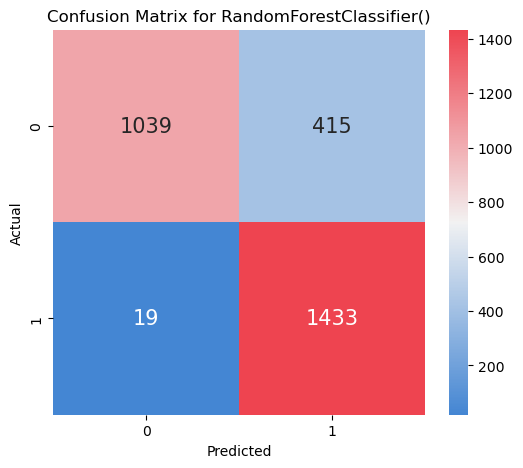

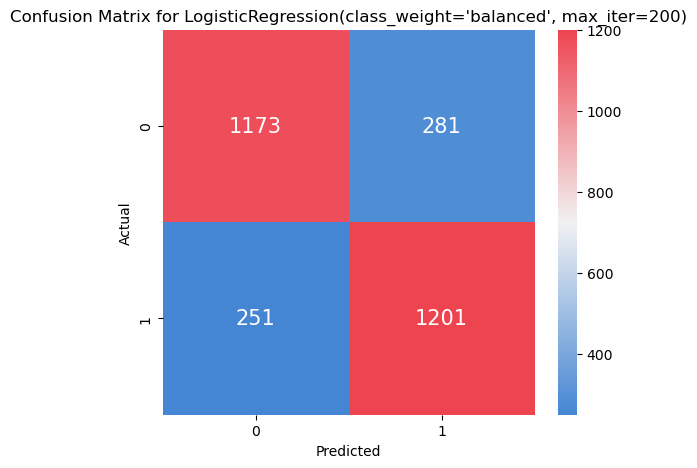

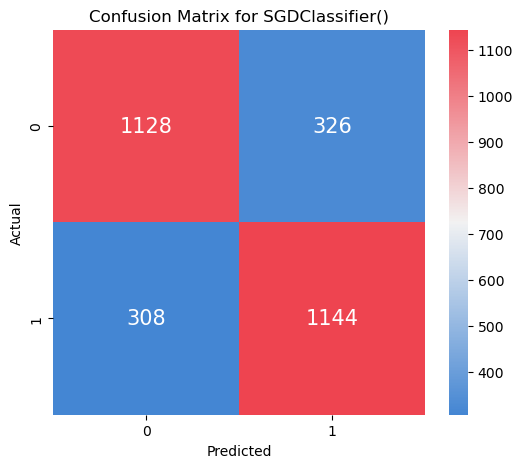

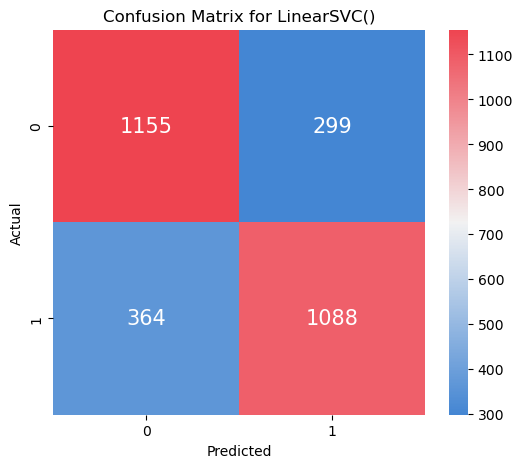

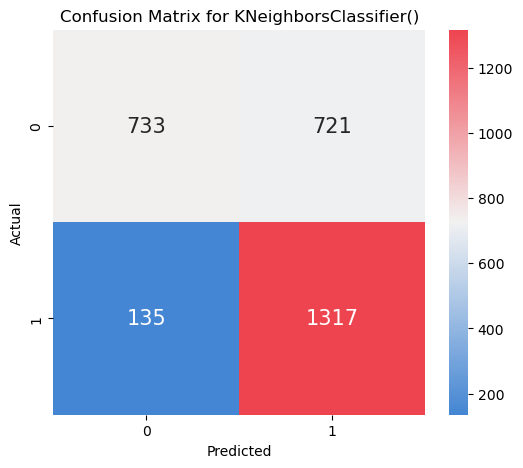

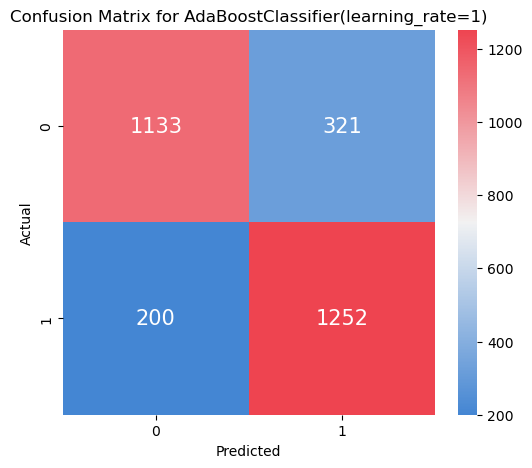

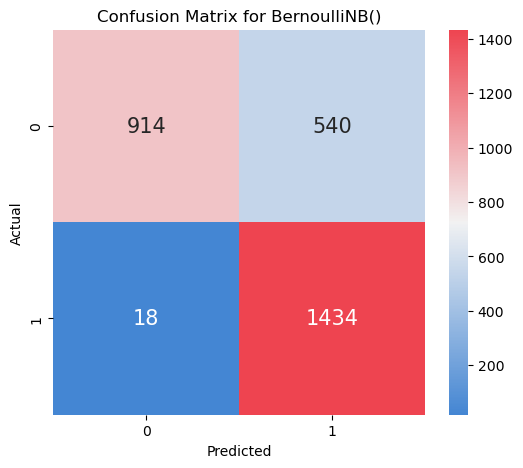

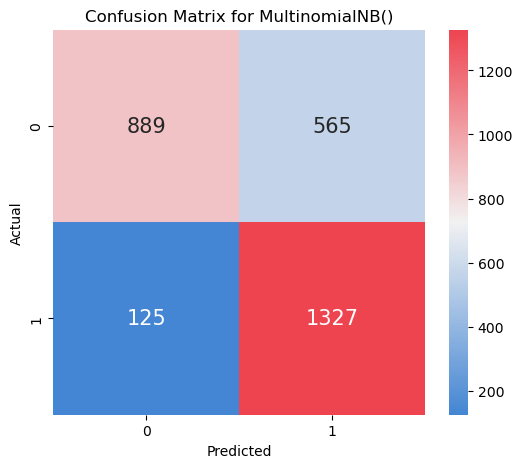

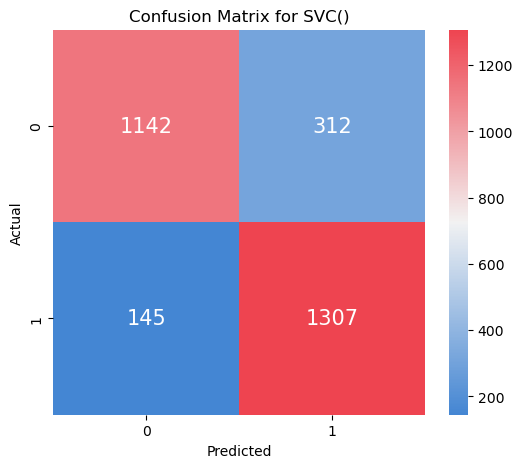

In [80]:
classifiers = [RandomForestClassifier(n_estimators=100),
               LogisticRegression(solver='lbfgs',class_weight='balanced', max_iter=200),
               SGDClassifier(),
               LinearSVC(),
               KNeighborsClassifier(n_neighbors=5),
               AdaBoostClassifier(n_estimators=50, learning_rate=1),
               BernoulliNB(),
               MultinomialNB(),
               svm.SVC()]

skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)

for classifier in classifiers:
    print(str(classifier))
    
    pocet = 0
    
    list_acc = []
    list_pre = []
    list_rec = []
    list_f1 = []
    list_matrix = []
    
    for train_index, test_index in skf.split(X, y):
        pocet += 1
        print(pocet)
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        if(str(classifier) == "MultinomialNB()"):
            scaler = MinMaxScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
        
            classifier.fit(X_train, y_train)
            y_pred = classifier.predict(X_test)
        
        else:
            classifier.fit(X_train, y_train)
            y_pred = classifier.predict(X_test)
        
        list_acc.append(accuracy_score(y_test, y_pred))
        list_pre.append(precision_score(y_test, y_pred))
        list_rec.append(recall_score(y_test, y_pred))
        list_f1.append(f1_score(y_test, y_pred))
        list_matrix.append(confusion_matrix(y_test, y_pred))
         
    print("Results for: "+ file+ " with classifier: "+ str(classifier))
    print("Average accuracy: {:.2f}%".format(np.mean(list_acc)*100))
    print("Average precision: {:.2f}%".format(np.mean(list_pre)*100))
    print("Average recall: {:.2f}%".format(np.mean(list_rec)*100))
    print("Average F1 score: {:.2f}%".format(np.mean(list_f1)*100))

    cmap = sns.diverging_palette(250, 10, s=80, l=55, n=9, as_cmap=True)
    plt.subplots(figsize=(6,5))
    sns.heatmap((list_matrix[0] + list_matrix[1]), cmap=cmap, annot=True, annot_kws={'size': 15}, fmt='g')

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title("Confusion Matrix for "+ str(classifier));    


In [ ]:
# glove dim 200, 10k, 10 words, neupravené
# Average accuracy: 75.00%
# Average precision: 73.44%
# Average recall: 78.36%
# Average F1 score: 75.81%



# dim=200, 50k sentences, 20 words per dataset
#Upravené vety: 
# Average accuracy: 79.55%
# Average precision: 80.18%
# Average recall: 78.52%
# Average F1 score: 79.33%

#Neupravené vety: 
# Average accuracy: 82.99%
# Average precision: 81.79%
# Average recall: 84.90%
# Average F1 score: 83.31%



# dim=200, 10k sentences, 10 words per dataset
#Upravené vety: 
# Average accuracy: 83.80%
# Average precision: 81.78%
# Average recall: 86.99%
# Average F1 score: 84.30%

#Neupravené vety: 
# Average accuracy: 81.28%
# Average precision: 78.03%
# Average recall: 87.08%
# Average F1 score: 82.31%

In [ ]:
model = LogisticRegression(solver='lbfgs', max_iter=200)
pocet = 0

skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)

list_acc = []
list_pre = []
list_rec = []
list_f1 = []
list_matrix = []

for train_index, test_index in skf.split(X, y):
    pocet+=1
    print(pocet)
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    
    list_acc.append(accuracy_score(y_test, y_pred))
    list_pre.append(precision_score(y_test, y_pred))
    list_rec.append(recall_score(y_test, y_pred))
    list_f1.append(f1_score(y_test, y_pred))
    list_matrix.append(confusion_matrix(y_test, y_pred))

print("Average accuracy: {:.2f}%".format(np.mean(list_acc)*100))
print("Average precision: {:.2f}%".format(np.mean(list_pre)*100))
print("Average recall: {:.2f}%".format(np.mean(list_rec)*100))
print("Average F1 score: {:.2f}%".format(np.mean(list_f1)*100))

cmap = sns.diverging_palette(250, 10, s=80, l=55, n=9, as_cmap=True)
plt.subplots(figsize=(6,5))
sns.heatmap((list_matrix[0] + list_matrix[1]), cmap=cmap, annot=True, annot_kws={'size': 15}, fmt='g')

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix');